<a href="https://colab.research.google.com/github/ajaychaudhary7/KnowledgeDistillation/blob/main/ResNet_Knowledge_Distillation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader

In [ ]:
class Teacher(nn.Module):
  def __init__(self, num_classes = 10):
    super(Teacher,self).__init__()
    self.resnet = torchvision.models.resnet50(pretrained=True)
    in_features = self.resnet.fc.in_features
    self.resnet.fc = nn.Linear(in_features,num_classes)

  def forward(self,x):
    return self.resnet(x)

# Define transformations and load MNIST dataset
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),  # Resize images to the input size of ResNet-50
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# MNIST dataset with transformations
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [ ]:
class Student(nn.Module):
    def __init__(self, num_classes=10):
        super(Student, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1)
        self.fc1 = nn.Linear(128 * 14 * 14, 128)  # Reduced the number of neurons in fc1
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv3(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv4(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
import gc
gc.collect()

52

In [ ]:
teacher_model = Teacher()
student_model = Student()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_model.to(device)
student_model.to(device)

criterion_hard = nn.CrossEntropyLoss()  # Hard target (ground truth) loss
criterion_soft = nn.KLDivLoss()  # Soft target (teacher's predictions) loss

optimizer = optim.Adam(student_model.parameters(), lr=0.001)

num_epochs = 5
temperature = 10  # Temperature parameter for softening the teacher's predictions
alpha = 0.7  # Weight for the soft target loss
teacher_model.eval()
student_model.train()

for epoch in range(num_epochs):
  for batch_idx, (inputs,targets) in enumerate(train_loader):
    inputs, targets = inputs.to(device),targets.to(device)
    optimizer.zero_grad()
    with torch.no_grad():
      teacher_output = teacher_model(inputs)
    student_output = student_model(inputs)
    hard_loss = criterion_hard(student_output,targets)
    # Compute soft target loss (knowledge distillation)
    soft_loss = criterion_soft(torch.log_softmax(student_output/temperature,dim=1),
                               torch.softmax(teacher_output/temperature,dim=1))

    total_loss = alpha * hard_loss + (1-alpha) * soft_loss
    total_loss.backward()
    optimizer.step()

    if batch_idx % 100 == 0:
      print('Epoch [{}/{}], Step [{}/{}], Hard Loss: {:.4f}, Soft Loss: {:.4f}'
        .format(epoch+1, num_epochs, batch_idx+1, len(train_loader), hard_loss.item(), soft_loss.item()))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2943: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch [1/5], Step [1/469], Hard Loss: 2.3000, Soft Loss: 0.0000
Epoch [1/5], Step [101/469], Hard Loss: 0.0202, Soft Loss: 0.0115
Epoch [1/5], Step [201/469], Hard Loss: 0.1669, Soft Loss: 0.0095
Epoch [1/5], Step [301/469], Hard Loss: 0.0559, Soft Loss: 0.0104
Epoch [1/5], Step [401/469], Hard Loss: 0.0372, Soft Loss: 0.0161
Epoch [2/5], Step [1/469], Hard Loss: 0.0279, Soft Loss: 0.0159
Epoch [2/5], Step [101/469], Hard Loss: 0.0240, Soft Loss: 0.0150
Epoch [2/5], Step [201/469], Hard Loss: 0.0251, Soft Loss: 0.0144
Epoch [2/5], Step [301/469], Hard Loss: 0.0198, Soft Loss: 0.0132
Epoch [2/5], Step [401/469], Hard Loss: 0.1351, Soft Loss: 0.0172
Epoch [3/5], Step [1/469], Hard Loss: 0.0199, Soft Loss: 0.0132
Epoch [3/5], Step [101/469], Hard Loss: 0.0045, Soft Loss: 0.0153
Epoch [3/5], Step [201/469], Hard Loss: 0.0105, Soft Loss: 0.0120
Epoch [3/5], Step [301/469], Hard Loss: 0.0103, Soft Loss: 0.0150
Epoch [3/5], Step [401/469], Hard Loss: 0.0045, Soft Loss: 0.0137
Epoch [4/5], Ste

In [ ]:
# Define transformations and load MNIST dataset
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),  # Resize images to the input size of ResNet-50
    transforms.ToTensor(),
])

# MNIST dataset with transformations
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
# Set the models to evaluation mode
teacher_model.eval()
student_model.eval()

validation_loss_student = 0.0
validation_loss_teacher = 0.0
num_batches = 0

with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        teacher_outputs = teacher_model(inputs)
        student_outputs = student_model(inputs)

        # Compute your validation loss, e.g., using CrossEntropyLoss for classification tasks
        loss_function = nn.CrossEntropyLoss()
        loss = loss_function(student_outputs, targets)
        teacher_loss = loss_function(teacher_outputs,targets)

        validation_loss_student += loss.item()
        validation_loss_teacher += teacher_loss.item()
        num_batches += 1

# Calculate the average validation loss
average_validation_loss_student = validation_loss_student / num_batches
average_validation_loss_teacher = validation_loss_teacher / num_batches


print(f'Average Validation Loss Student: {average_validation_loss_student:.4f}')
print(f'Average Validation Loss Teacher: {average_validation_loss_teacher:.4f}')



Average Validation Loss Student: 0.0381
Average Validation Loss Teacher: 2.2953


In [ ]:
# Save trained models
torch.save(teacher_model.state_dict(), 'teacher_model.pth')
torch.save(student_model.state_dict(), 'student_model.pth')


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

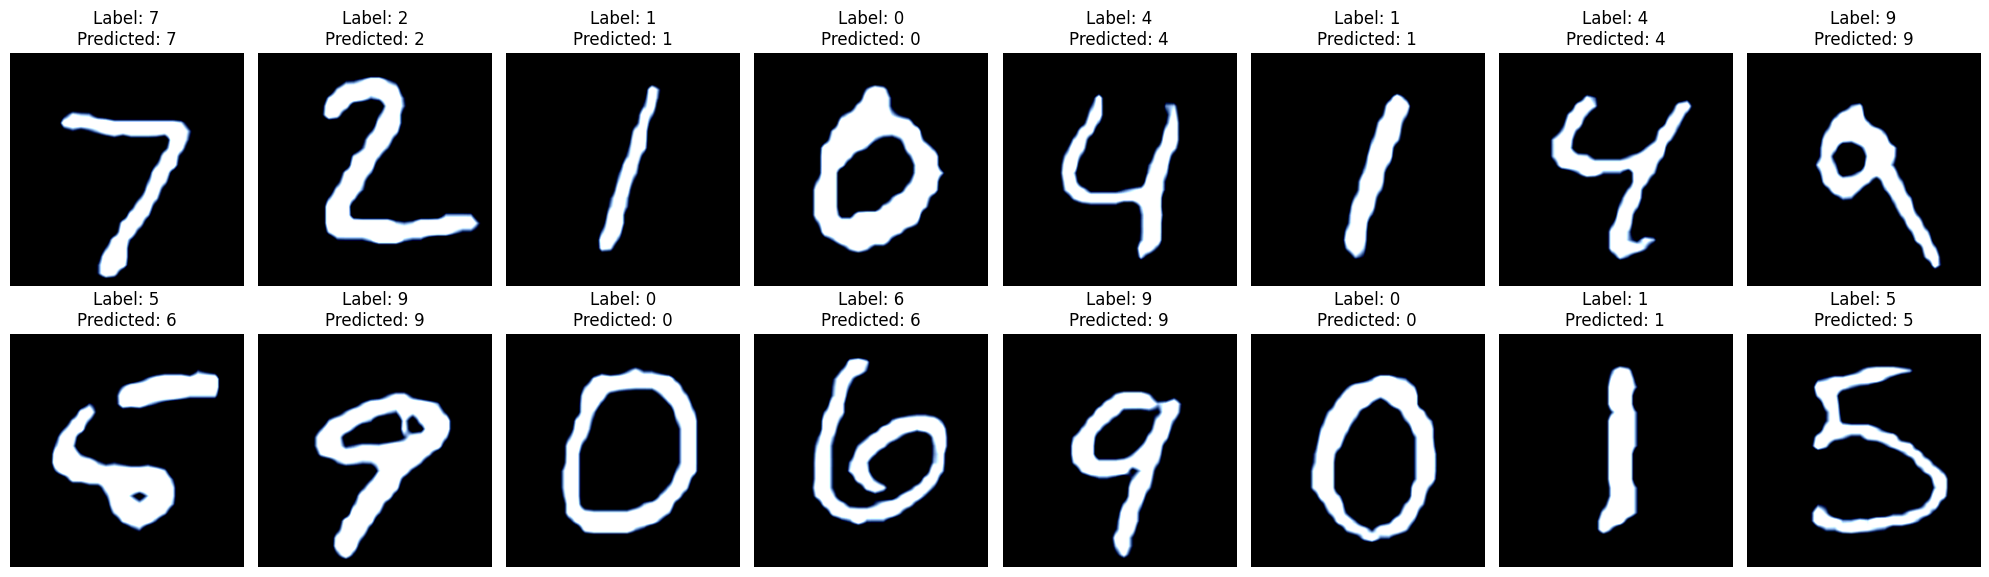

In [ ]:
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Forward pass through the student model
with torch.no_grad():
    outputs = student_model(images)

# Get predicted labels
_, predicted = torch.max(outputs, 1)

# Convert predictions to a list
predicted_list = predicted.tolist()

# Plot the images and predictions (display 16 images)
fig, axs = plt.subplots(2, 8, figsize=(20, 6))
axs = axs.flatten()

for i in range(16):
    img = images[i].cpu().numpy().transpose((1, 2, 0))  # Convert torch tensor to numpy array
    axs[i].imshow(img)
    axs[i].set_title(f'Label: {labels[i]}\nPredicted: {predicted_list[i]}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Count the number of trainable parameters in the student model
num_trainable_params_student = sum(p.numel() for p in student_model.parameters() if p.requires_grad)
print(f"Number of trainable parameters in student model: {num_trainable_params_student}")

# Count the number of trainable parameters in the teacher model
num_trainable_params_teacher = sum(p.numel() for p in teacher_model.parameters() if p.requires_grad)
print(f"Number of trainable parameters in teacher model: {num_trainable_params_teacher}")

params_reduced = (num_trainable_params_student/num_trainable_params_teacher) * 100

print(f"Number of trainable params in student compared to teacher: {params_reduced} %")

Number of trainable parameters in student model: 3310122
Number of trainable parameters in teacher model: 23528522
Number of trainable params in student compared to teacher: 14.068550502237242 %


In [ ]:
# Instantiate ResNet-50 model
resnet50_model = torchvision.models.resnet50(pretrained=False, num_classes=10)  # Set num_classes to 10 for MNIST

# Count the number of trainable parameters in the ResNet-50 model
num_trainable_params_resnet50 = sum(p.numel() for p in resnet50_model.parameters() if p.requires_grad)
print(f"Number of trainable parameters in ResNet-50 model: {num_trainable_params_resnet50}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Number of trainable parameters in ResNet-50 model: 23528522


In [ ]:
!pip install torchviz --quiet

In [ ]:
# Generate a random input tensor (batch size of 1, 3 channels, 224x224 image)
from torchviz import make_dot
import torch.nn.functional as F
dummy_input = torch.rand(1, 3, 224, 224).to(device)

# Create a network diagram
output = student_model(dummy_input)
network_diagram = make_dot(output, params=dict(student_model.named_parameters()))

# Save the network diagram as a PDF file
network_diagram.format = 'pdf'
network_diagram.render("student_model_diagram")

'student_model_diagram.pdf'

In [ ]:
from torchsummary import summary
summary(student_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
            Conv2d-2         [-1, 32, 112, 112]           4,640
            Conv2d-3           [-1, 64, 56, 56]          18,496
            Conv2d-4          [-1, 128, 28, 28]          73,856
            Linear-5                  [-1, 128]       3,211,392
            Linear-6                   [-1, 10]           1,290
Total params: 3,310,122
Trainable params: 3,310,122
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 11.49
Params size (MB): 12.63
Estimated Total Size (MB): 24.69
----------------------------------------------------------------
